### TO DO 
* ~Include account attributes in query~   
* ~Append account attributes to final output~  
* revisit original query to find a more straightforward way of doing this. Duplicate edge format complicates separating/grouping attributes
* Script to generate more summary statistics for output
* Fix pdf output  
* Fix regex group error https://stackoverflow.com/questions/39901550/python-userwarning-this-pattern-has-match-groups-to-actually-get-the-groups  
* Add gephx file output

In [2]:
import pandas as pd
import numpy as np
import networkx as nx
#import pyodbc
import sqlite3
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.gridspec as gridspec

%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 6)
plt.style.use('ggplot')

conn = sqlite3.connect('demo_data.db')

In [13]:
# if using live datamart
t_sql_query = '''
select  a.member_nbr [source], concat((c.first_name + space(1) + c.last_name + space(1)),  a.individual_id) [target] , a.participation_type
from membershipparticipant_today a

--left join agr_membertotal_today b on a.member_nbr = b.member_nbr
left join individual_today c on a.individual_id = c.individual_id
'''

# if using sqlite demo database
sqlite_query = '''
select  
    a.member_nbr [source], 
    c.first_name || ' ' || c.last_name || ' '||  a.individual_id [target] , 
    a.participation_type, b.open_loan_bal

from membershipparticipant_today a

left join agr_membertotal_today b on a.member_nbr = b.member_nbr
left join individual_today c on a.individual_id = c.individual_id
'''

attribute_query = '''
select member_nbr, open_loan_bal
from agr_membertotal_today

'''

In [4]:
def get_network_members(degree_dictionary):
    td = pd.DataFrame.from_dict(degree_dictionary)
    names = td.loc[td[0].str.contains(r"([" "] | [a-z])", na=False)]
    names = names.rename(columns={0:'name/individual ID', 1:'degrees'})
    member_nbrs = td.loc[~td.index.isin(names.index)]
    member_nbrs = member_nbrs.rename(columns={0:'member_nbr', 1:'degrees'})

    return(names, member_nbrs)

def generate_color_map(graph_object):
    individual_nodes = []
    for name in list(graph_object.nodes):
        if " " in str(name):
            individual_nodes.append(name)
    
    for n in graph_object.nodes:
        graph_object.nodes[n]['color'] = 'c' if n in individual_nodes else 'm'
    
    colors = [node[1]['color'] for node in graph_object.nodes(data = True)]
    return(colors)

In [5]:
d = pd.read_sql(sqlite_query, conn)
d

,source,target,participation_type,open_loan_bal
0,7503,Oliver Zavala 9960,101,0
1,3987,Mackenzie Choi 8846,101,1100423
2,4924,Elena Gross 5941,101,29848
3,4364,Daniela Huffman 1951,101,586220
4,5565,Summer Wade 6572,101,333471
...,...,...,...,...
145,4718,Summer Wade 6572,101,1226645
146,5192,Oliver Zavala 9960,101,1121609
147,7646,Autumn Quintero 6996,101,274546
148,3660,Riley Bush 668,101,0


In [14]:
attributes = pd.read_sql(attribute_query, conn)
attributes

,member_nbr,open_loan_bal
0,8201,0
1,7179,1110742
2,5648,1233484
3,1560,362404
4,7708,399710
...,...,...
97,6131,0
98,7673,869592
99,7163,0
100,6653,1102779


### Basic stats

In [16]:
G = nx.from_pandas_edgelist(d, edge_attr = True)
print(nx.info(G))
print('connected components: ' +str(nx.number_connected_components(G)))

Name: 
Type: Graph
Number of nodes: 202
Number of edges: 150
Average degree:   1.4851
connected components: 52


In [17]:
# Degrees
degree = nx.degree(G)
degree

DegreeView({7503: 1, 'Oliver Zavala 9960': 2, 3987: 1, 'Mackenzie Choi 8846': 1, 4924: 3, 'Elena Gross 5941': 1, 4364: 1, 'Daniela Huffman 1951': 3, 5565: 1, 'Summer Wade 6572': 2, 7985: 3, 'Isaac Carlson 1499': 2, 2863: 2, 'Mary Mcgee 3841': 1, 3676: 1, 'Everett Frazier 9307': 1, 3811: 2, 'Bryce Dixon 2367': 1, 4651: 1, 'Liliana Stephenson 3598': 1, 7163: 1, 'Brayden George 1973': 2, 2240: 1, 'Micah Lynch 7307': 2, 6653: 1, 'Cora Spencer 8965': 1, 3055: 1, 'Amir Jensen 1757': 1, 6131: 2, 'Isabella Williams 7293': 1, 2387: 1, 'Bryce Terry 6035': 1, 3232: 1, 'Preston Crane 1359': 2, 2047: 1, 'Mya Clay 1306': 2, 8528: 2, 'Riley Bush 668': 3, 2813: 3, 'Isaac Lang 3687': 4, 5437: 2, 'Josephine Woods 1126': 1, 7708: 1, 'Taylor Butler 6638': 1, 1225: 2, 'Elijah Shepard 7905': 1, 4764: 3, 'Carlos Valencia 3145': 1, 6431: 2, 'Mark Yoder 5980': 1, 3357: 3, 'Emery Case 4717': 2, 7008: 2, 'Eden Cochran 7309': 2, 7524: 3, 'Katherine Pham 2040': 1, 3838: 3, 'Rachel Schroeder 7067': 1, 6117: 1, 'Con

[1, 2, 1, 1, 3, 1, 1, 3, 1, 2, 3, 2, 2, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 2, 2, 3, 3, 4, 2, 1, 1, 1, 2, 1, 3, 1, 2, 1, 3, 2, 2, 2, 3, 1, 3, 1, 1, 2, 2, 2, 3, 1, 2, 2, 1, 1, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 6, 2, 2, 1, 2, 1, 3, 3, 1, 1, 1, 1, 2, 2, 1, 3, 5, 1, 2, 1, 2, 1, 3, 2, 1, 1, 1, 2, 1, 1, 1, 1, 3, 2, 1, 1, 1, 2, 1, 2, 3, 1, 1, 1, 2, 2, 2, 4, 1, 2, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 1, 2, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


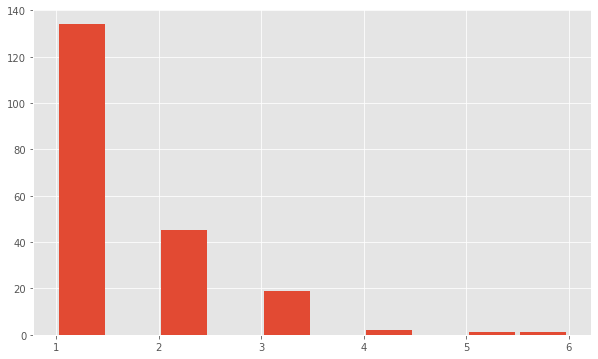

In [18]:
#Degree histogram
plt.rcParams['figure.figsize'] = (10, 6)
degrees = [node[1] for node in degree]
print (degrees)
plt.hist(degrees, bins=10, rwidth=0.9)
plt.show()

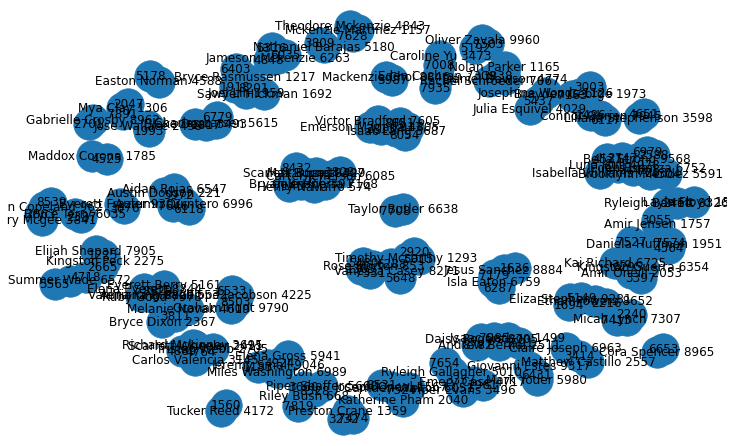

In [19]:
# Show all participants
pos = nx.spring_layout(G)
nx.draw(G, pos=pos,   node_size=1000)
nx.draw_networkx_labels(G, pos=pos )
plt.show()

### Data prep and examining subgraphs

In [20]:
# make subgraphs from all the connected components within the original dataset
S = [G.subgraph(c).copy() for c in nx.connected_components(G)]

In [21]:
# node count summary statisitcs of subgraphs
node_count = []
for sub in S:
    count = len(nx.nodes(sub))
    node_count.append(count)
    
print(f'min nodes {min(node_count)}')
print(f'max nodes {max(node_count)}')
print(f'average nodes {sum(node_count)/len(node_count)}')


min nodes 2
max nodes 10
average nodes 3.8846153846153846


In [22]:
# filter for subgraphs with n nodes

n =6 
multi=[]
for sub in S:
    nodes = nx.nodes(sub)
    node_count = len(nodes)
    if node_count>=n:
        multi.append(sub)

print(f'{len(multi)} networks with at least {n} nodes')

9 networks with at least 6 nodes


In [23]:
## Code for flattening a subgraph 
#flat_list = [item for sublist in list(multi[0].edges) for item in sublist ]

#degree view
list(multi[0].degree)

#edge view
list(multi[0].edges)

#nodes
list(multi[0].nodes)

[8782,
 7985,
 5591,
 'Andrew Bernal 2511',
 'Isaac Carlson 1499',
 'Daisy Rogers 8705']

In [24]:
# set colors
source_nodes = list(d['source'])#set([edge[0] for edge in d])
target_nodes = list(d['target'])
for n in G.nodes():
    G.nodes[n]['color'] = 'b' if n in source_nodes else 'o'
colors = [node[1]['color'] for node in G.nodes(data=True)]

In [25]:
def get_network_members(degree_dictionary):
    td = pd.DataFrame.from_dict(degree_dictionary)
    names = td.loc[td[0].str.contains(r"([" "] | [a-z])", na=False)]
    names = names.rename(columns={0:'name/individual ID', 1:'degrees'})
    member_nbrs = td.loc[~td.index.isin(names.index)]
    member_nbrs = member_nbrs.rename(columns={0:'member_nbr', 1:'degrees'})

    return(names, member_nbrs)

In [26]:
t = nx.get_edge_attributes(G, 'open_loan_bal')
t

{(7503, 'Oliver Zavala 9960'): 0,
 ('Oliver Zavala 9960', 5192): 1121609,
 (3987, 'Mackenzie Choi 8846'): 1100423,
 (4924, 'Elena Gross 5941'): 29848,
 (4924, 'Miles Washington 6989'): 29848,
 (4924, 'Jeremy Small 9046'): 29848,
 (4364, 'Daniela Huffman 1951'): 586220,
 ('Daniela Huffman 1951', 7527): 997665,
 ('Daniela Huffman 1951', 7574): 497978,
 (5565, 'Summer Wade 6572'): 333471,
 ('Summer Wade 6572', 4718): 1226645,
 (7985, 'Isaac Carlson 1499'): 1151063,
 (7985, 'Andrew Bernal 2511'): 1151063,
 (7985, 'Daisy Rogers 8705'): 1151063,
 ('Isaac Carlson 1499', 5591): 1298777,
 (2863, 'Mary Mcgee 3841'): 0,
 (2863, 'Eden Copeland 962'): 0,
 (3676, 'Everett Frazier 9307'): 599572,
 (3811, 'Bryce Dixon 2367'): 665514,
 (3811, 'Melanie Novak 4619'): 665514,
 (4651, 'Liliana Stephenson 3598'): 0,
 (7163, 'Brayden George 1973'): 0,
 ('Brayden George 1973', 3003): 896131,
 (2240, 'Micah Lynch 7307'): 0,
 ('Micah Lynch 7307', 7415): 651278,
 (6653, 'Cora Spencer 8965'): 1102779,
 (3055, 'Am

In [32]:
def get_member_nbr_attributes(attribute_dataframe, node_dataframe):
    attributes = pd.merge(node_dataframe, attribute_dataframe, on = 'member_nbr')
    return(attributes)
    

In [28]:
def generate_color_map(graph_object):
    individual_nodes = []
    
    for name in list(graph_object.nodes):
        if " " in str(name):
            individual_nodes.append(name)
    
    for n in graph_object.nodes:
        graph_object.nodes[n]['color'] = 'c' if n in individual_nodes else 'm'
    
    colors = [node[1]['color'] for node in graph_object.nodes(data = True)]
    return(colors)

the 7985 network
6 nodes


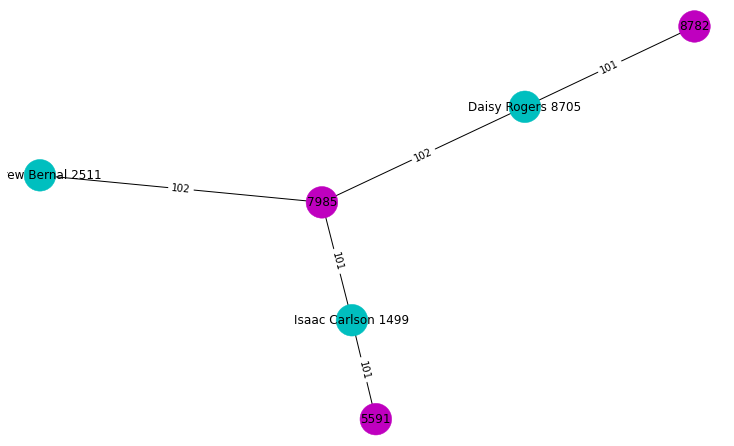

   name/individual ID  degrees
3  Andrew Bernal 2511        1
4  Isaac Carlson 1499        2
5   Daisy Rogers 8705        2
  member_nbr  degrees  open_loan_bal
0       8782        1              0
1       7985        3        1151063
2       5591        1        1298777


In [33]:
#specify subgraph
graph = multi[0]

colors = generate_color_map(graph)

#find center of graph and use it to determine name
center = nx.center(graph)
title = f'the {str(center[0])} network'

#determine number of degrees and nodes
degrees = nx.degree(graph)
node_count = len(nx.nodes(graph))

#layout for display
pos = nx.spring_layout(graph)

#function to separate membership from individuals for display
names,member_nbrs = get_network_members(degrees)

#function to join attributes back on subgraph node
at = get_member_nbr_attributes(attributes,member_nbrs )

#draw function
nx.draw(graph, pos=pos, node_color=colors, node_size=1000)

#add labels
nx.draw_networkx_labels(graph, pos=pos )
edge_labels = nx.get_edge_attributes(graph, 'participation_type')
nx.draw_networkx_edge_labels(graph, pos, edge_labels)

#Output
print(title)
print(f'{node_count} nodes')
plt.show()
#print(pd.DataFrame.from_dict(nx.degree(graph)))
print(names)
print(at)

The 7985 network
6 nodes


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\strings\accessor.py:101: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


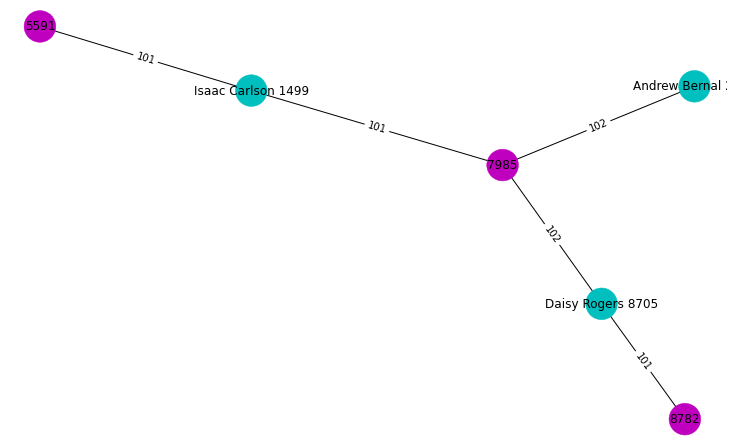

   name/individual ID  degrees
3  Andrew Bernal 2511        1
4  Isaac Carlson 1499        2
5   Daisy Rogers 8705        2
  member_nbr  degrees  open_loan_bal
0       8782        1              0
1       7985        3        1151063
2       5591        1        1298777
The Isaac Lang 3687 network
7 nodes


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\strings\accessor.py:101: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


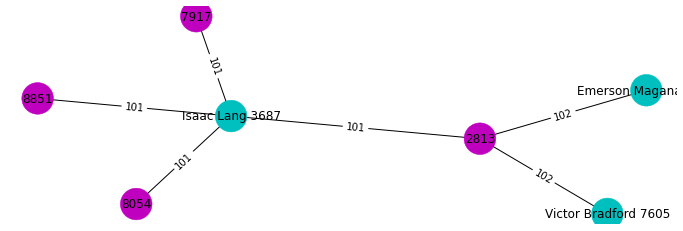

   name/individual ID  degrees
3  Andrew Bernal 2511        1
4  Isaac Carlson 1499        2
5   Daisy Rogers 8705        2
  member_nbr  degrees  open_loan_bal
0       7917        1          24411
1       8851        1         700710
2       8054        1         843818
3       2813        3              0
The 3357 network
6 nodes


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\strings\accessor.py:101: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


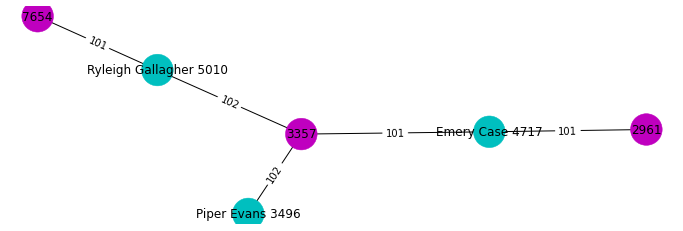

   name/individual ID  degrees
3  Andrew Bernal 2511        1
4  Isaac Carlson 1499        2
5   Daisy Rogers 8705        2
  member_nbr  degrees  open_loan_bal
0       7654        1        1137323
1       2961        1        1247386
2       3357        3        1148442
The 5972 network
6 nodes


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\strings\accessor.py:101: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


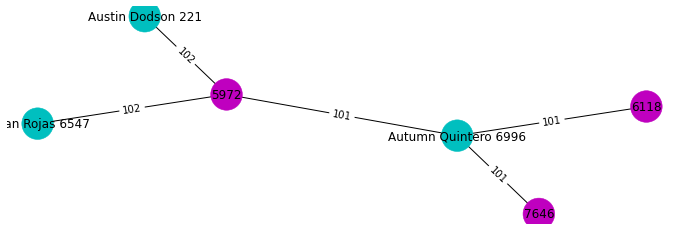

   name/individual ID  degrees
3  Andrew Bernal 2511        1
4  Isaac Carlson 1499        2
5   Daisy Rogers 8705        2
  member_nbr  degrees  open_loan_bal
0       6118        1         531759
1       5972        3         384191
2       7646        1         274546
The 8201 network
6 nodes


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\strings\accessor.py:101: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


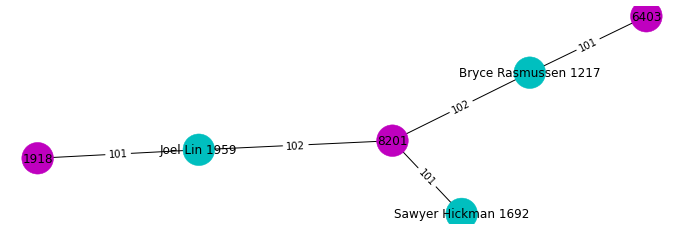

   name/individual ID  degrees
3  Andrew Bernal 2511        1
4  Isaac Carlson 1499        2
5   Daisy Rogers 8705        2
  member_nbr  degrees  open_loan_bal
0       6403        1         551485
1       8201        3              0
2       1918        1              0
The 7673 network
10 nodes


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\strings\accessor.py:101: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


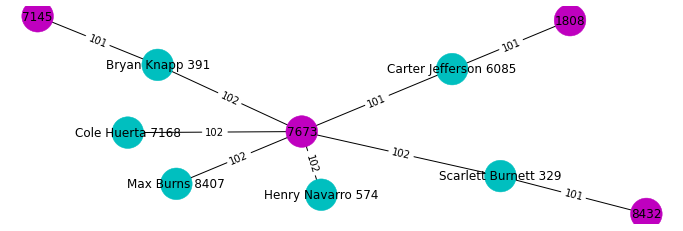

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\strings\accessor.py:101: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


   name/individual ID  degrees
3  Andrew Bernal 2511        1
4  Isaac Carlson 1499        2
5   Daisy Rogers 8705        2
  member_nbr  degrees  open_loan_bal
0       7145        1         929845
1       8432        1         961348
2       1808        1          44890
3       7673        6         869592
The 6288 network
10 nodes


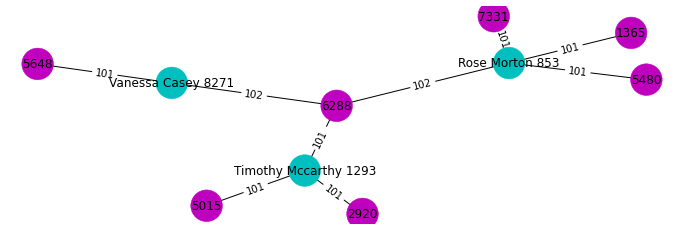

   name/individual ID  degrees
3  Andrew Bernal 2511        1
4  Isaac Carlson 1499        2
5   Daisy Rogers 8705        2
  member_nbr  degrees  open_loan_bal
0       7331        1         832459
1       2920        1         316780
2       5480        1              0
3       6288        3         911273
4       5648        1        1233484
5       1365        1         395550
6       5015        1         954759
The 8929 network
6 nodes


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\strings\accessor.py:101: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


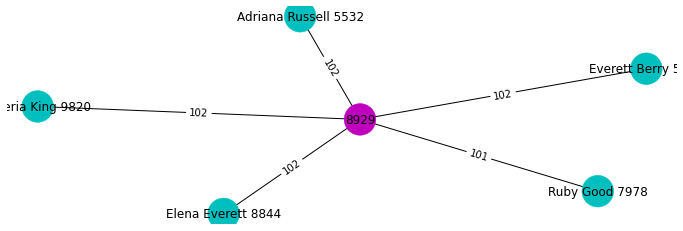

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\strings\accessor.py:101: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


   name/individual ID  degrees
3  Andrew Bernal 2511        1
4  Isaac Carlson 1499        2
5   Daisy Rogers 8705        2
  member_nbr  degrees  open_loan_bal
0       8929        5         702638
The 5443 network
7 nodes


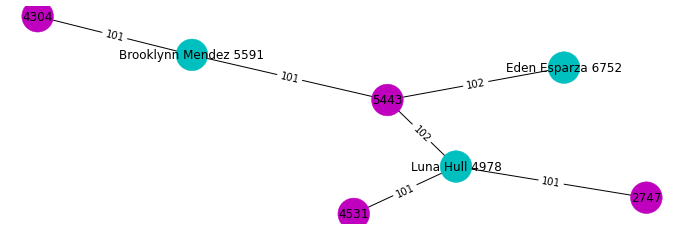

   name/individual ID  degrees
3  Andrew Bernal 2511        1
4  Isaac Carlson 1499        2
5   Daisy Rogers 8705        2
  member_nbr  degrees  open_loan_bal
0       5443        3        1117901
1       4304        1         929415
2       4531        1        1495465
3       2747        1              0


IndexError: list index out of range

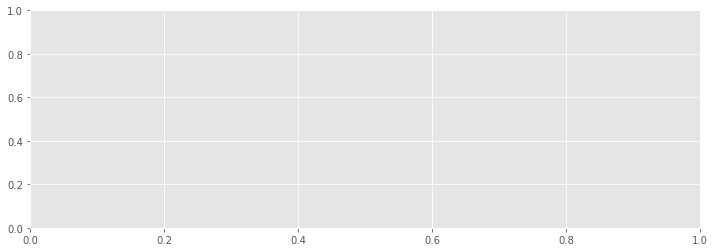

In [34]:
for i in range(10):
    
    graph = multi[i]
    
    individual_nodes = []

    for name in list(graph.nodes):
        if " " in str(name):
            individual_nodes.append(name)

    for n in graph.nodes:
        graph.nodes[n]['color']= 'c' if n in individual_nodes else 'm'
    
    colors = [node[1]['color'] for node in graph.nodes(data=True)]
    
    center = nx.center(graph)
    title = 'The '+str(center[0])+" network"
    degrees = nx.degree(graph)
    node_count = len(nx.nodes(graph))
    pos = nx.spring_layout(graph)
    
    names,member_nbrs = get_network_members(degrees)
    
    nx.draw(graph, pos=pos, node_color=colors,   node_size=1000)

    nx.draw_networkx_labels(graph, pos=pos )
    edge_labels = nx.get_edge_attributes(graph, 'participation_type')
    nx.draw_networkx_edge_labels(graph, pos, edge_labels)
    
    #function to join attributes back on subgraph node
    at = get_member_nbr_attributes(attributes,member_nbrs )
    
    print(title)
    print(str(node_count)+" nodes")
    plt.show()
    #print(pd.DataFrame.from_dict(nx.degree(graph)))
    print(x)
    print(at)
    
    
    fig, ax =plt.subplots(figsize=(12,4))
ax.axis('tight')
ax.axis('off')
the_table = ax.table(cellText=df.values,colLabels=df.columns,loc='center')

#https://stackoverflow.com/questions/4042192/reduce-left-and-right-margins-in-matplotlib-plot
pp = PdfPages("foo.pdf")
pp.savefig(fig, bbox_inches='tight')
pp.close()